In [55]:
from sklearn import metrics
!pip install scipy numpy matplotlib pandas sklearn tabulate seaborn folium geopy geopandas requests> /dev/null
%matplotlib notebook

In [6]:
# import importlib
# import sys
# importlib.reload(sys.modules['statistics.company'])
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, learning_curve, permutation_test_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tabulate import tabulate
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os
import sys
sys.path.insert(0, os.path.abspath('./module-dir'))

In [8]:
from dataset_provider.provider import get_dataset
from dataset_provider.config import create_global_config
df = get_dataset(create_global_config())

Taking data from local file...
Found 304 job ads without salary range or currency
(1249, 75)
        salary_from     salary_to
count   1249.000000   1249.000000
mean   11148.760608  15884.851081
std     4540.909690   5114.312359
min     1250.000000   1750.000000
25%     8000.000000  12100.000000
50%    10000.000000  16000.000000
75%    14000.000000  19000.000000
max    44000.000000  50000.000000
Found 8 countries and 4 currencies!
Dropping foreign countries and translating currencies...
Unique countries: 1, currencies: 1, observations: 1230


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


---------------------------------------------------------------------------

# Regression

In [9]:
def move_col_to_end(df, col):
    cols_at_end = [col]
    return df[[c for c in df if c not in cols_at_end] 
            + [c for c in cols_at_end if c in df]]

In [11]:
cl_df = df.copy()
for col in ["salary_to", "city", "Unnamed: 0", "title", "company_size", "country_code", "marker_icon", "company_name",
            "latitude", "longitude", "salary_currency", "published_at", "remote_interview", "id",
            "Vert.x", "skills", "-"]:
                cl_df=cl_df.drop(col, axis=1)

In [12]:
cl_df.columns

Index(['remote', 'experience_level', 'salary_from', 'employment_type', '.NET',
       'Design', 'Network', 'REST API', 'Embeded', 'Cloud', 'Database',
       'Android', 'IT', 'Soft Skills', 'Scrum master', 'Mobile', 'Common',
       'JavaScript', 'DevOps', 'Software engineering', 'Testing', 'Automation',
       'Shell Scripting', 'Backend', 'Data Science', 'Blockchain', 'C++',
       'Client Service', 'Front-end', 'Civil Engineering', 'Developer', 'iOS',
       'SQL', 'Python', 'PHP', 'Erlang', 'Scala', 'Git', 'Games', 'Golang',
       'Google', 'Java', 'Web', 'Consultant', 'Project Manager', 'Analitics',
       'CRM', 'Perl', 'R', 'Ruby', 'Rust', 'SAP', 'CSS', 'XML', 'Salesforce',
       'API', 'Data', 'Excel'],
      dtype='object')

In [13]:
# cl_df.loc[df["Backend"] > 0] = cl_df.loc[df["Backend"] > 0]

In [14]:
cols_for_encoding = [c for c in cl_df.select_dtypes(include=['object', 'boolean']).copy().columns]
cl_df = pd.get_dummies(cl_df, columns=cols_for_encoding)
cl_df = move_col_to_end(cl_df, "salary_from")
array = cl_df.values
x = array[:, 0:len(cl_df.columns)-1]
y = array[:, len(cl_df.columns)-1]
x = normalize(x)
print(x[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.91766294 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.22941573 0.         0.         0.         0.22941573 0.22941573
 0.         0.        ]


In [16]:
# x_train, x_validation, y_train, y_validation = train_test_split(x,y, test_size=cfg.test_size, random_state=1)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # doctest: +SKIP
scaler.fit(x)  # doctest: +SKIP
x = scaler.transform(x)

In [18]:
cl_df.columns

Index(['.NET', 'Design', 'Network', 'REST API', 'Embeded', 'Cloud', 'Database',
       'Android', 'IT', 'Soft Skills', 'Scrum master', 'Mobile', 'Common',
       'JavaScript', 'DevOps', 'Software engineering', 'Testing', 'Automation',
       'Shell Scripting', 'Backend', 'Data Science', 'Blockchain', 'C++',
       'Client Service', 'Front-end', 'Civil Engineering', 'Developer', 'iOS',
       'SQL', 'Python', 'PHP', 'Erlang', 'Scala', 'Git', 'Games', 'Golang',
       'Google', 'Java', 'Web', 'Consultant', 'Project Manager', 'Analitics',
       'CRM', 'Perl', 'R', 'Ruby', 'Rust', 'SAP', 'CSS', 'XML', 'Salesforce',
       'API', 'Data', 'Excel', 'remote_False', 'remote_True',
       'experience_level_junior', 'experience_level_mid',
       'experience_level_senior', 'employment_type_b2b',
       'employment_type_mandate_contract', 'employment_type_permanent',
       'salary_from'],
      dtype='object')

Best parameters below (CV score=3642.025):


lasso__alpha,lasso__max_iter,lasso__random_state,pca__n_components
1.91,100,True,1


<IPython.core.display.Javascript object>


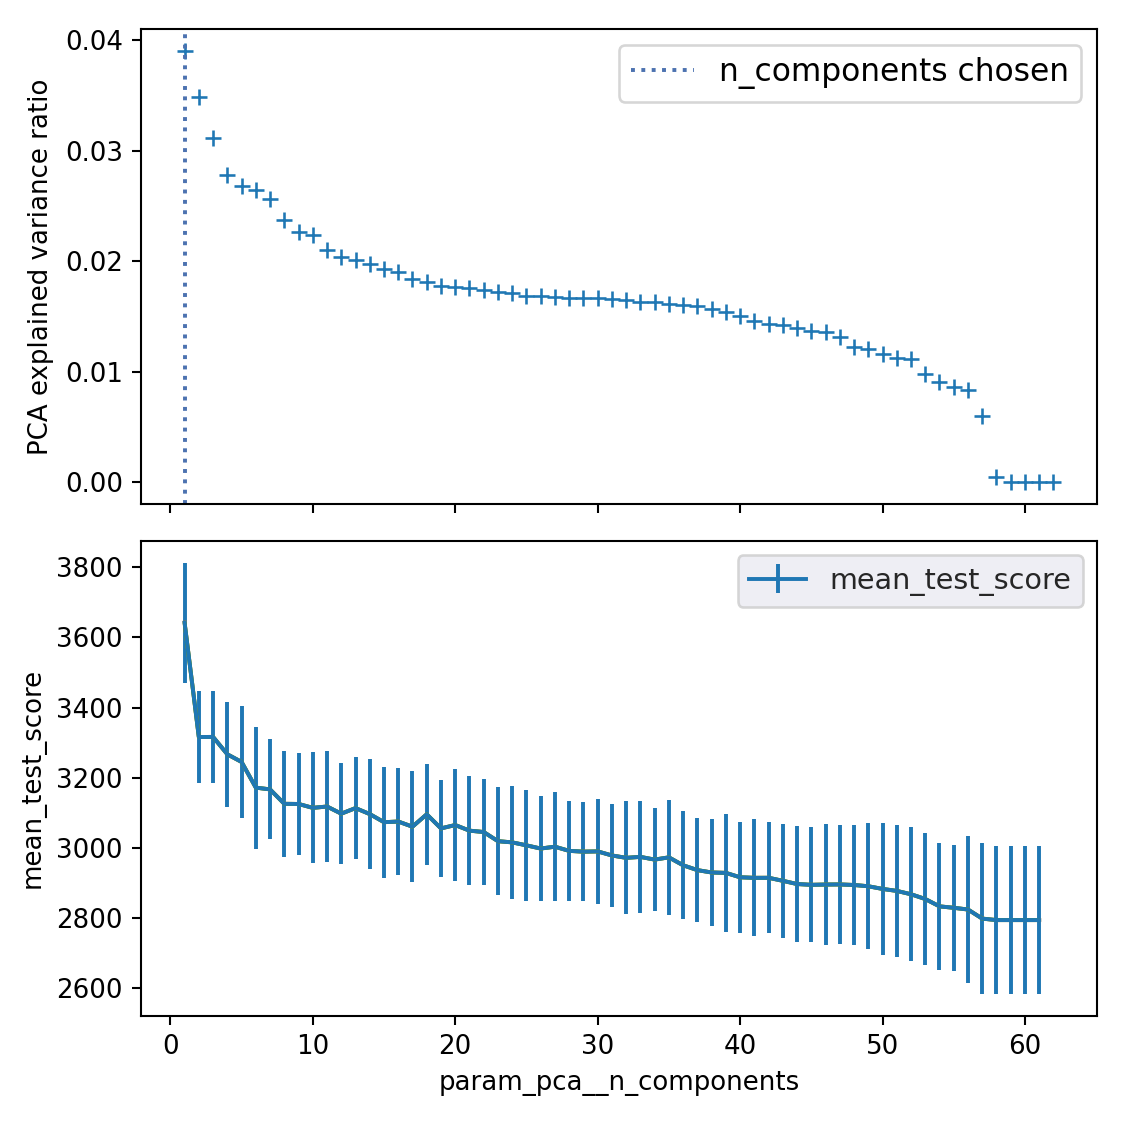

In [56]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from numpy import arange

def try_all_params_combinations(x, y, name, model, params):
    # update params keys to format name__model-name to fit to grid
    for key in params.keys():
        params[f"{name}__{key}"] = params.pop(key)

    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), (name, model)])
    param_grid = {'pca__n_components': range(1, len(x[0]))} # leave 1-all features
    param_grid.update(params)
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring=make_scorer(mean_absolute_error))
    search.fit(x, y)
    print("Best parameters below (CV score=%0.3f):" % search.best_score_)
    display(tabulate([list(search.best_params_.values())], list(search.best_params_.keys()), tablefmt="html"))
    
    # Plot the PCA spectrum
    pca.fit(x)
    
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, '+', linewidth=2)
    ax0.set_ylabel('PCA explained variance ratio')
    ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = 'param_pca__n_components'
    best_clfs = results.groupby(components_col).apply( lambda g: g.nlargest(1, 'mean_test_score'))
    best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=True, ax=ax1)
    ax1.set_xlabel('n_components')

    plt.tight_layout()
    plt.show()
    return search

# ---------------- Runtime ------------------------ #
models = [
    ('lasso', Lasso(), {
        'alpha': [1.91], 'max_iter': [100, 100_00, 100_000], 'random_state': [True]
    })
    ]
best_models = {}
for name, model, params in models:
    best_models[name] = try_all_params_combinations(x, y, name, model, params)

---------------------------------------------------------------------------

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, Lasso, ElasticNet, Lars, OrthogonalMatchingPursuit, SGDRegressor, ARDRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV, HuberRegressor, TheilSenRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_data(axes, title, x_train, y_train, x_test, y_test):
    axes.set_title(title)
    axes.scatter(x_train[:,0], y_train, color="green"),
    axes.plot(x_test, y_test, color="red", linewidth=1)
    
models = [
#     LinearRegression(),
#     HuberRegressor(alpha=0.00001, epsilon=1.6, max_iter=5000),
#     BayesianRidge(),
    AdaBoostRegressor(DecisionTreeRegressor(criterion='friedman_mse', max_depth=7, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=0.007,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               presort=False, random_state=1, splitter='best'),
                      random_state=3, n_estimators=120),
    DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=0.007,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               presort=False, random_state=1, splitter='best'),
    RandomForestRegressor(n_estimators=2000, oob_score=True, random_state=1000),
#     SGDRegressor(),
#     ARDRegression(),
#     TheilSenRegressor(),
#     MultiTaskLasso(),
#     MultiTaskLassoCV(),
#     OrthogonalMatchingPursuit(),
#     Lars(),
#     MLPRegressor(hidden_layer_sizes=(9), solver='lbfgs', tol=1e-6, learning_rate='adaptive', max_iter=3000, n_iter_no_change=100),
#     MLPRegressor(hidden_layer_sizes=(9), alpha=1e-8, solver='lbfgs', tol=1e-6, learning_rate='adaptive', max_iter=3000, n_iter_no_change=100),
#     MLPRegressor(hidden_layer_sizes=(9), alpha=1, solver='lbfgs', tol=1e-6, learning_rate='adaptive', max_iter=3000, n_iter_no_change=100),
#     MLPRegressor(hidden_layer_sizes=(16), solver='sgd', learning_rate='adaptive', max_iter=500, n_iter_no_change=100),
#     SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
#     SVR(kernel='poly', C=100, gamma='scale', degree=3, epsilon=.1, coef0=1),
#     SVR(kernel='linear', C=100, gamma='scale'),
#     SVR(kernel='rbf'),
#     SVR(kernel='poly', degree=60, gamma='scale'),
#     SVR(kernel='linear', gamma='scale'),    
#     SVR(kernel='sigmoid', gamma='scale'),
#     SVR(kernel='precomputed', gamma='auto'),
    Lasso(alpha=0.1, max_iter=1000_00, random_state=True),
    ElasticNet(alpha=0.01, max_iter=1000_00, random_state=True)
    ]

# f, axarr = plt.subplots(len(models), sharex=True, sharey=True,figsize=(12,12))
for y, model in enumerate(models):
        y_test = model.fit(x_train, y_train).predict(x_validation)
#         plot_data(axarr[y], type(model).__name__, x_train, y_train, x_validation, y_test)
        print(f"{type(model).__name__} MAE: {mean_absolute_error(y_validation, y_test, )} | MSE: {mean_squared_error(y_validation, y_test, )}")

In [ ]:
for i, y in enumerate(y_validation):
    print(f"predicted: {y_test[i]} original: {y_validation[i]}")